# Data Mining / Prospecção de Dados

## Sara C. Madeira and André Falcão, 2019/20

# Project 1 - Pattern Mining

## Introduction

**In what follows keep the following question in mind and be creative!**

1. What are the most popular products?
2. Which products are bought together?
3. Can you find associations highliting that when people buy a product/set of products also buy other product(s)?

To facilitate the analyses required to complete the project, I developed a rudimentary python module *PP_mining*. 

This module contains useful functions:

* `max_itemsets`
* `store_groups`
* `get_n`

And the `Pattern Class`:

``` 
Pattern class is an api extension for pattern mining python libraries. That facilitates quick analyses,by providing an abstraction layer, with easy to handle objects. (It's a rudimentary implementation)

It was designed to work with 'MLxtend', but can be easily expanded to work with other PM libs.
```

The full documentation can be consulted alongside with the code for easier interpretation.

Since it extends on `MLxtend` all 3 implemented algorithms for computing frequent itemsets are available:

* `FPGrowth`
* `FPMax`
* `Apriori`

But only the first 2 were used. I choose to use `FPgrowth` based implementations, because it's faster, and uses less memory. `Apriori` can be faster if run in parallel, but `MLxtend`, has of this moment, does not use multiprocessing techniques. And adding to this, `MLxtend` does not actually uses the `Apriori`, uses a slower approximation as reported in [Issue#644](https://github.com/rasbt/mlxtend/issues/644).

Having these implementation specific characteristics in mind, the comparison table below, makes my choice obvious.

![algo](algo.png)

*From:https://www.quora.com/What-is-the-difference-between-FPgrowth-and-Apriori-algorithms-in-terms-of-results*

## 1. Mining Frequent Itemsets and Association Rules: Ignoring Product Quantities and Stores

In this first part of the project you should load and preprocessed the dataset **`Foodmart_2020_PD.csv`** in order to compute frequent itemsets and generate association rules considering all the transactions, regardeless of the store, and ignoring product quantities.

### 1.1. Load and Preprocess Dataset

 **Product quantities and stores should not be considered.**

In [1]:
# Import Libraries

import os
from pp_mining import Pattern, store_groups, get_n, max_itemsets, draw_graph
from statistics import mean, stdev
import matplotlib.pyplot as plt

#Get directory to files

path = os.getcwd()
path = os.path.join(path,"dataset")
csv_file = os.path.join(path,"Foodmart_2020_PD.csv")

In [2]:
# Load data
all_stores = Pattern(csv_path=csv_file)
all_stores.dataset.head()

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,...,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### EDA

In [132]:
print('{} Items'.format(len(all_stores.dataset.columns)))
print('{} Transactions'.format(len(all_stores.dataset.values)))

102 Items
69549 Transactions


The dataset has many items to evaluate, but it has good proportions (features << datapoints)

In [91]:
percents = []
items = all_stores.dataset.columns
for item in items:
    percents.append(all_stores.dataset[item].value_counts('True')[1])
print('Mean Presence: {} % [+- {}]'.format(round(mean(percents)*100,1), round(stdev(percents)*100, 1)))
print('Maximum Presence: {} %'.format(round(max(percents)*100,1)))
print('Minimum Presence: {} %'.format(round(min(percents)*100,1)))

Mean Presence: 4.1 % [+- 3.7]
Maximum Presence: 28.4 %
Minimum Presence: 1.3 %


Having a minimum inside the mean's standard deviation, and a maximum that is clearly an outlier, we can access that most items will probably have a small presence in transactions, with some items dominating most of the transactions.

This is most be taken into account, since basic algorithms like **FPGrowth**, or **Apriori** have a basic approach to computing support (single support), which leads to a preference for itemsets with items that have an high presence in transactions. Not having in consideration if an item is a frequently selling item, like basic groceries, or a less frequently sold item, like a computer. A possible solution is using an algorithm that uses a support matrix like **MLApriori**.

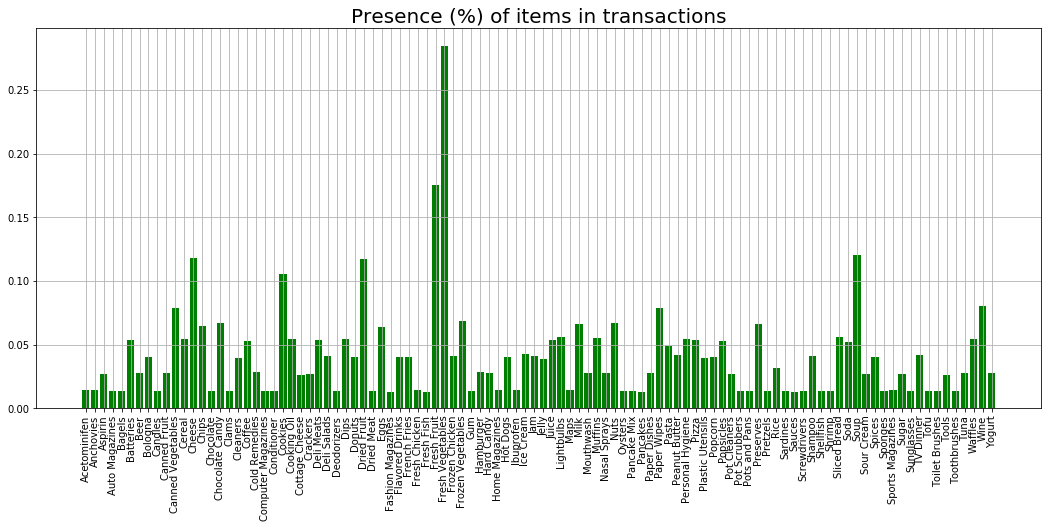

In [129]:
plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.ocean(1)
plt.bar(items, percents, color=color)
plt.title('Presence (%) of items in transactions', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

Has expected, we have two main outliers, and lots of products sold with a low frequency. Another possible solution, is to remove the outliers, to find other less obvious patterns.

In [97]:
N = 10
top = get_n(percents, items, N)
top

{'Canned Vegetables': 0.07854893672087306,
 'Cheese': 0.11784497260923953,
 'Cookies': 0.1054220765215891,
 'Dried Fruit': 0.11722670347524766,
 'Fresh Fruit': 0.1752864886626695,
 'Fresh Vegetables': 0.28446131504406963,
 'Frozen Vegetables': 0.06834030683403068,
 'Paper Wipes': 0.07896590892751873,
 'Soup': 0.1200592388100476,
 'Wine': 0.08067693280996133}

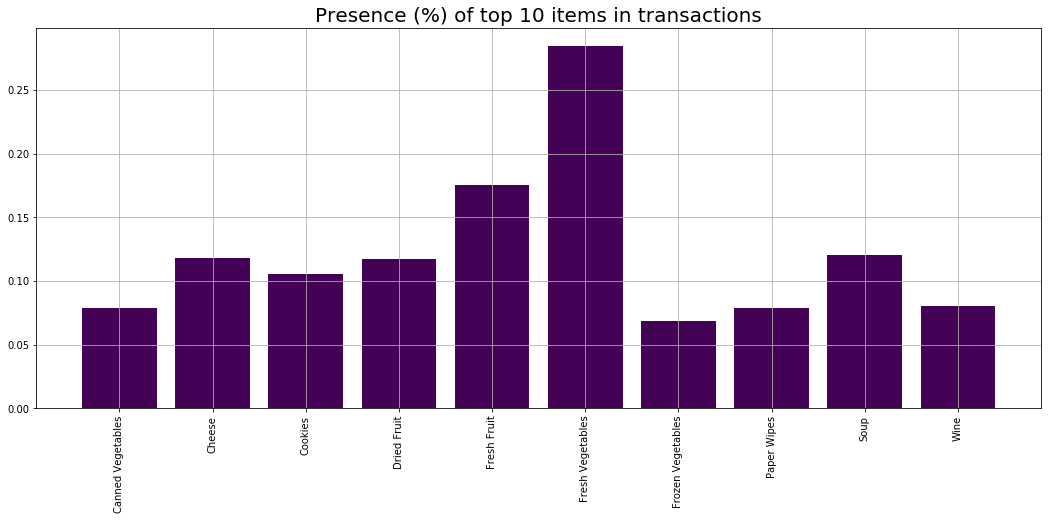

In [107]:
plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.viridis(1)
plt.bar(list(top.keys()), list(top.values()), color=color)
plt.title('Presence (%) of top {} items in transactions'.format(N), fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

Most sold items are, as expected, basic fresh groceries, that need to be bought daily. Analysing which items are bought with this items might be useful, since it tells us what products are sold as extras when people go to buy essencials. Moving this products closer together could entice costumers.  

In [125]:
N = 50
bottom = get_n(percents, items, N, top=False)

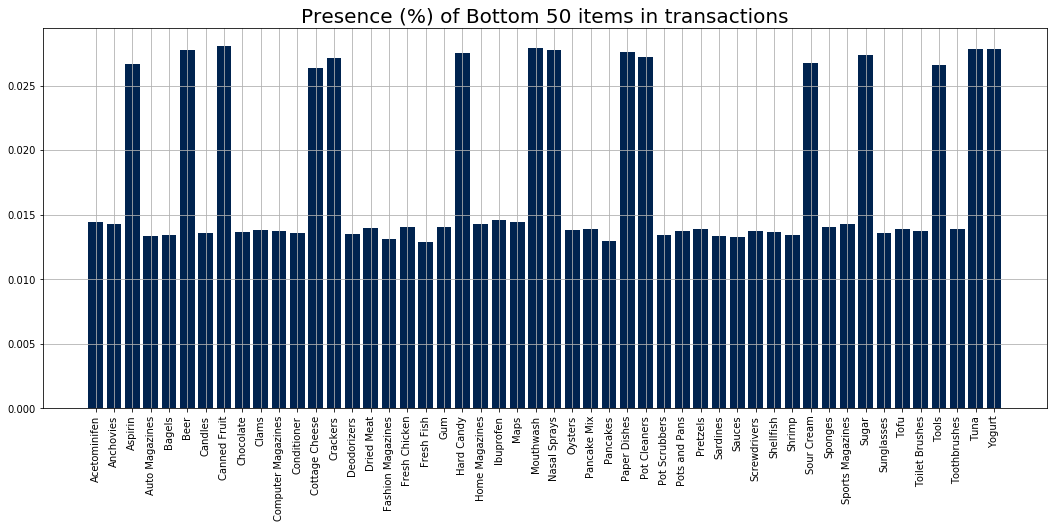

In [126]:
plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.cividis(1)
plt.bar(list(bottom.keys()), list(bottom.values()), color=color)
plt.title('Presence (%) of Bottom {} items in transactions'.format(N), fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

The less sold are more specific items, that can be bought many at a time, in fewer transactions, and since we are not considering, the quantities bought, this items have a visible disadvantage. Since less sold items are much more consistence in terms of consistency, to we might want to remove some outliers in a posterior analyses.

Considering this dataset, and the approach proposed in this project, I would conclude that the analyses that would obtain better results, is opportunist analyses. Where we try to associate daily sold products, that are the reason people normally engage in these transactions, and see what are the non-essencial products, people can be entice to buy.

### 1.2. Compute Frequent Itemsets

* Compute frequent itemsets considering a minimum support of X%. 
* Present frequent itemsets organized by length (number of items). 
* List frequent 1-itemsets, 2-itemsets, 3-itemsets, etc with support of at least Y%.
* Change X and Y when it makes sense and discuss the results.

#### Top support

In [12]:
min_support=0.1

frequent = all_stores.create_item_set(min_support=min_support, order=False)

print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head()

6 Itemsets with at least 10.0 % support


,support,itemsets
0,0.120059,(Soup)
1,0.284461,(Fresh Vegetables)
2,0.117845,(Cheese)
3,0.105422,(Cookies)
4,0.175286,(Fresh Fruit)


In [17]:
frequent.sort_values('support', ascending=False, inplace=True)
frequent.reset_index(drop=True, inplace=True)
frequent

,support,itemsets
0,0.284461,(Fresh Vegetables)
1,0.175286,(Fresh Fruit)
2,0.120059,(Soup)
3,0.117845,(Cheese)
4,0.117227,(Dried Fruit)
5,0.105422,(Cookies)


By considering a high support (given this dataset), the top selling products appear again, with only 1-itemsets. In this list we have 3 items that need to be bought daily, and 3 products I would access, as convenience products. It will be interesting to see possible association between them.

#### Organized by length

In [166]:
min_support=0.005

frequent = all_stores.create_item_set(min_support=min_support, ascending=False)

print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head(10)

374 Itemsets with at least 0.5 % support


,support,itemsets
0,0.005334,"(Cheese, Fresh Fruit, Fresh Vegetables)"
1,0.005550,"(Cookies, Fresh Fruit, Fresh Vegetables)"
2,0.007089,"(Soup, Fresh Fruit, Fresh Vegetables)"
3,0.010884,"(French Fries, Fresh Vegetables)"
4,0.013990,"(Waffles, Fresh Vegetables)"
5,0.007592,"(Chips, Cheese)"
6,0.018332,"(Chips, Fresh Vegetables)"
7,0.007304,"(Chips, Dried Fruit)"
8,0.010985,"(Chips, Fresh Fruit)"
9,0.006542,"(Cottage Cheese, Fresh Vegetables)"


The support needs to drop bellow 0.5%, to some 3-itemsets to appear. But we see that as expected, they are normally the combination of essencial, and convenience products.

##### 1-Itemsets

In [188]:
min_support=0.05

frequent = all_stores.create_item_set(min_support=min_support, order=False, length=[1,1])

print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head(10)

31 Itemsets with at least 5.0 % support


,support,itemsets
0,0.120059,(Soup)
1,0.284461,(Fresh Vegetables)
2,0.066342,(Milk)
3,0.117845,(Cheese)
4,0.105422,(Cookies)
5,0.066040,(Preserves)
6,0.064070,(Eggs)
7,0.054868,(Dips)
8,0.054321,(Cereal)
9,0.053617,(Deli Meats)


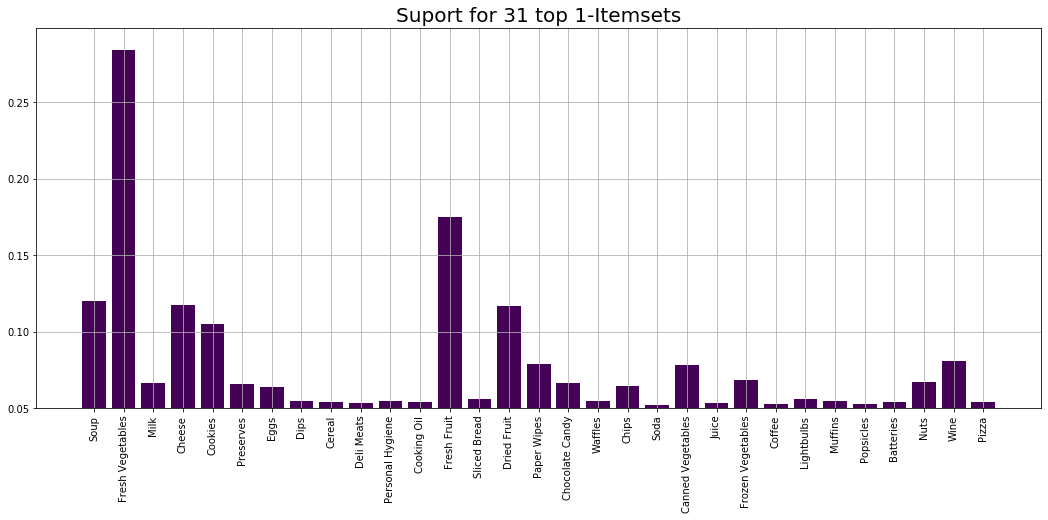

In [189]:
items = [list(item_set)[0] for item_set in frequent['itemsets'].values]

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.viridis(1)
plt.bar(items, frequent['support'].values, color=color)
plt.title('Support for {} top 1-Itemsets'.format(len(frequent)), fontsize = 20)
plt.xticks(rotation = 90 )
plt.ylim(bottom=min_support)
plt.grid()
plt.show()

The 1-itemsets, are very similar to what was already discussed in initial exploratory analyses. We have many items that are usually bought daily, or from opportunity. I would add one remark though, a simple reason this products may also be more frequently bought, is because most of them are cheap, and they are part of most contemporary diets. 

It's easier to induce people into buying cheaper products, that people can eat on spot. This prays on the costumers hunger. 

##### 2-Itemsets

In [21]:
min_support=0.015

frequent = all_stores.create_item_set(min_support=min_support, order=False, length=[2,2])

print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head(10)

30 Itemsets with at least 1.5 % support


,support,itemsets
0,0.035701,"(Fresh Vegetables, Soup)"
1,0.020805,"(Soup, Fresh Fruit)"
2,0.017757,"(Fresh Vegetables, Milk)"
3,0.015227,"(Cheese, Soup)"
4,0.020417,"(Cheese, Fresh Fruit)"
5,0.031201,"(Fresh Vegetables, Cheese)"
6,0.027765,"(Fresh Vegetables, Cookies)"
7,0.018908,"(Cookies, Fresh Fruit)"
8,0.019051,"(Fresh Vegetables, Preserves)"
9,0.018016,"(Fresh Vegetables, Eggs)"


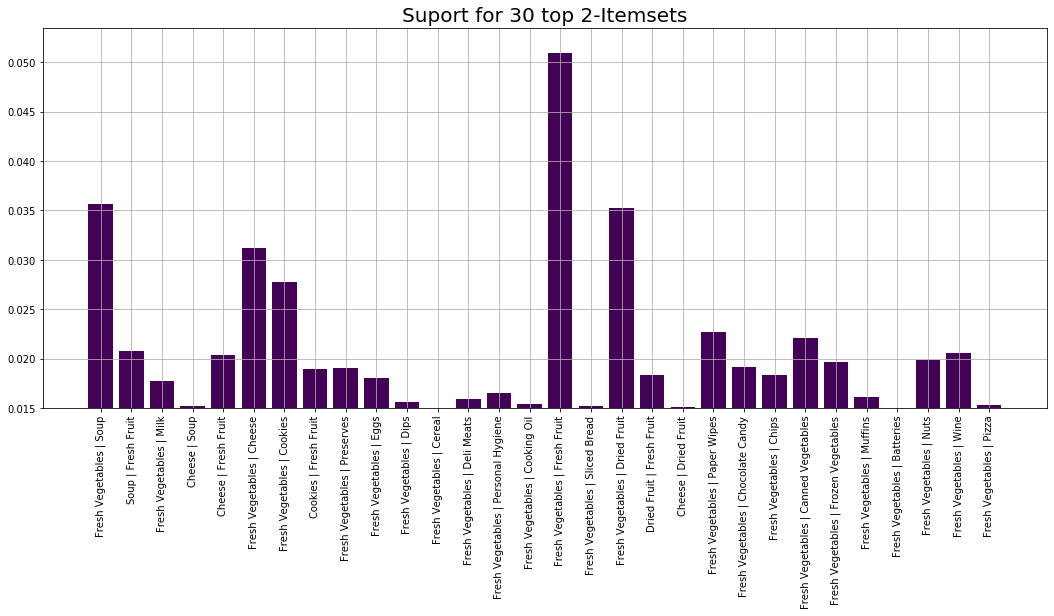

In [22]:
itemsets = ['{} | {}'.format(list(item_set)[0], list(item_set)[1]) for item_set in frequent['itemsets'].values]

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.viridis(1)
plt.bar(itemsets, frequent['support'].values, color=color)
plt.title('Support for {} top 2-Itemsets'.format(len(frequent)), fontsize = 20)
plt.xticks(rotation = 90 )
plt.ylim(bottom=min_support)
plt.grid()
plt.show()

Most 2-Itemsets, have at least one of the main 3 daily bought products (Fresh Vegetables, Fresh Fruit, Soup). This goes in agreement with what was discussed so far. Cookies and dried fruits, are amongst the most bought non-essentials. 

Given the already discussed constrains, when evaluating itemsets with bigger length the minimum support needs to be exponentially reduced.

##### 3-Itemsets

In [19]:
min_support=0.003

frequent = all_stores.create_item_set(min_support=min_support, order=False, length=[3,3])

print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head(10)

19 Itemsets with at least 0.3 % support


,support,itemsets
0,0.007089,"(Fresh Vegetables, Soup, Fresh Fruit)"
1,0.003451,"(Fresh Vegetables, Milk, Fresh Fruit)"
2,0.004285,"(Fresh Vegetables, Soup, Cheese)"
3,0.005334,"(Fresh Vegetables, Cheese, Fresh Fruit)"
4,0.005550,"(Fresh Vegetables, Cookies, Fresh Fruit)"
5,0.003897,"(Fresh Vegetables, Soup, Cookies)"
6,0.003782,"(Fresh Vegetables, Cookies, Dried Fruit)"
7,0.003221,"(Fresh Vegetables, Preserves, Fresh Fruit)"
8,0.003710,"(Fresh Vegetables, Soup, Dried Fruit)"
9,0.004975,"(Fresh Vegetables, Dried Fruit, Fresh Fruit)"


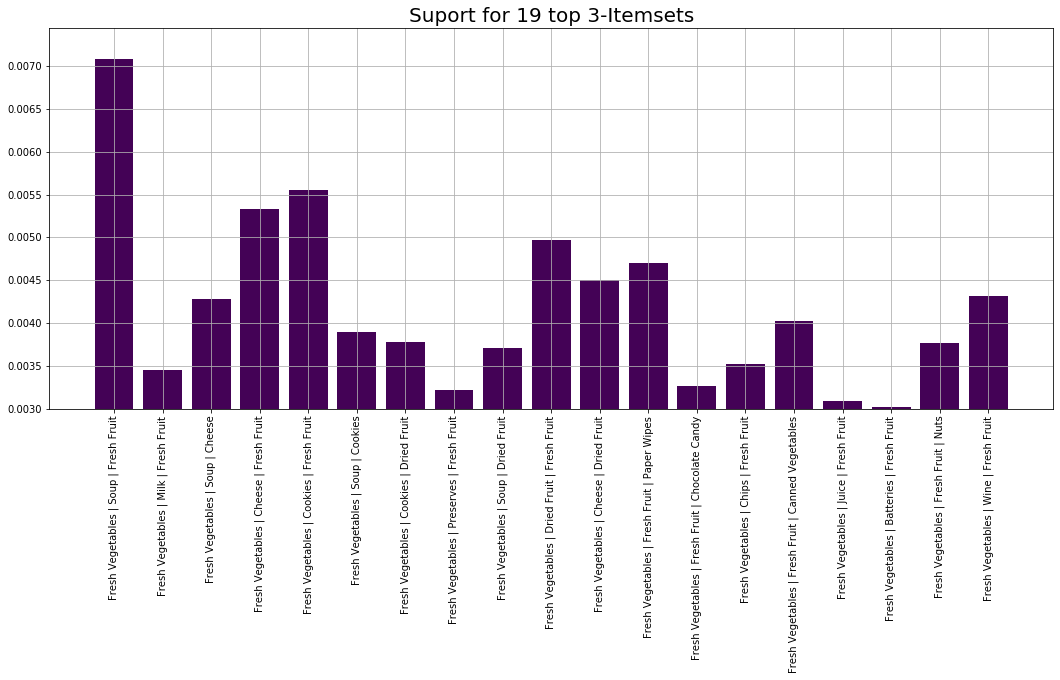

In [20]:
itemsets = ['{} | {} | {}'.format(list(item_set)[0], list(item_set)[1], list(item_set)[2]) 
            for item_set in frequent['itemsets'].values]

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.viridis(1)
plt.bar(itemsets, frequent['support'].values, color=color)
plt.title('Support for {} top 3-Itemsets'.format(len(frequent)), fontsize = 20)
plt.xticks(rotation = 90 )
plt.ylim(bottom=min_support)
plt.grid()
plt.show()

Again we mainly observe combinations of daily products with non essentials like cookies, cheese and dried fruit. Depending on the type of store many different strategies could be sought to entice clients to buy the maximum number of convenience products. 

##### 4-Itemsets

In [26]:
min_support=0.0005

frequent = all_stores.create_item_set(min_support=min_support, order=False, length=[4,4])

print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head(10)

18 Itemsets with at least 0.05 % support


,support,itemsets
0,0.000532,"(Fresh Vegetables, Soup, Milk, Fresh Fruit)"
1,0.000834,"(Fresh Vegetables, Soup, Cheese, Fresh Fruit)"
2,0.000546,"(Fresh Vegetables, Cookies, Cheese, Fresh Fruit)"
3,0.000748,"(Fresh Vegetables, Soup, Cookies, Fresh Fruit)"
4,0.000776,"(Fresh Vegetables, Cookies, Dried Fruit, Fresh..."
5,0.000518,"(Fresh Vegetables, Preserves, Cheese, Fresh Fr..."
6,0.000561,"(Fresh Vegetables, Soup, Fresh Fruit, Cereal)"
7,0.000618,"(Fresh Vegetables, Dried Fruit, Cheese, Fresh ..."
8,0.000546,"(Fresh Vegetables, Fresh Fruit, Dried Fruit, P..."
9,0.000518,"(Fresh Vegetables, Soup, Chips, Fresh Fruit)"


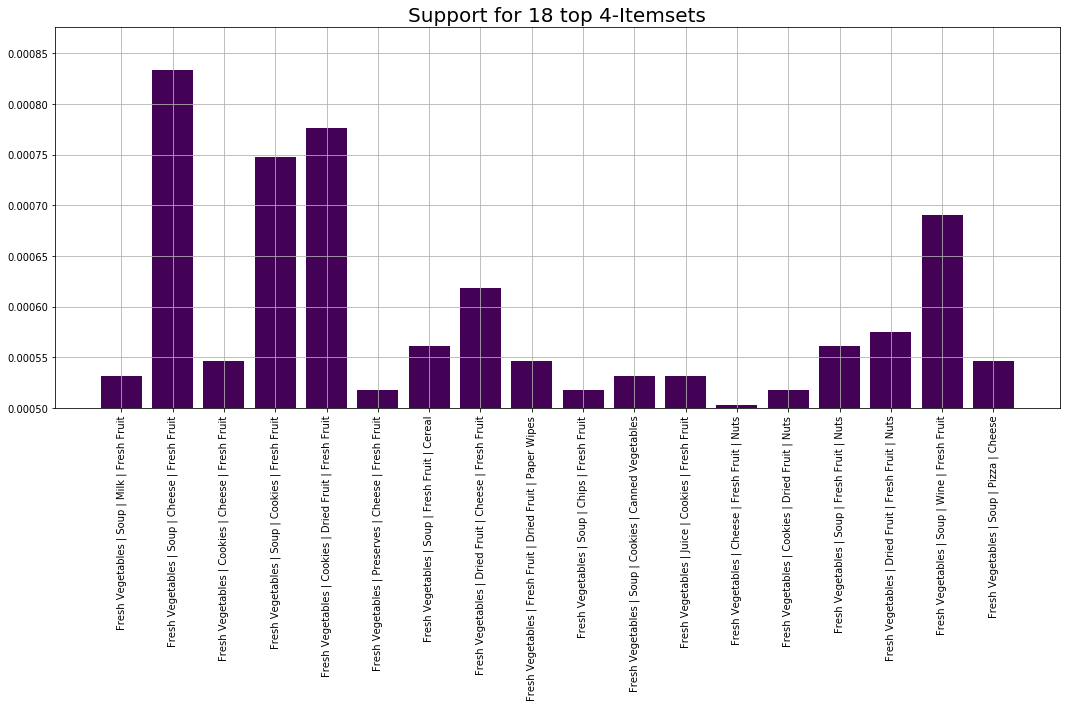

In [28]:
itemsets = ['{} | {} | {} | {}'.format(list(item_set)[0], list(item_set)[1], list(item_set)[2], list(item_set)[3])  
            for item_set in frequent['itemsets'].values]

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.viridis(1)
plt.bar(itemsets, frequent['support'].values, color=color)
plt.title('Support for {} top 4-Itemsets'.format(len(frequent)), fontsize = 20)
plt.xticks(rotation = 90 )
plt.ylim(bottom=min_support)
plt.grid()
plt.show()

At this level its important to have have in mind we are dealing with itemsets that have a very low support. Mostly itemsets follow the predictions already made.

In short the common itemsets are different combinations of:

* Daily products (Fresh Vegetables, Fresh Fruit, Soup)
* Convenience products (Cookies, Cheese, Dried Fruit, Wine)

Bigger itemsets tend to have many daily products, and only one convenience product, has expected.

A possible strategy would be to separate daily products in different parts of the store, and always have a convenience product close by. If they are in places costumers need to go but separately, costumers are probably more likely to buy, since other products already bought more likely to be forgotten. Also it makes costumers wander though the store, increasing the possibility of buying something.

### 1.3. Generate Association Rules from Frequent Itemsets

* Generate association rules with a minimum confidence of C%. 
* Generate association rules with a minimum lift L. 
* Generate association rules with both confidence >= % and lift >= 1.1.
* Change C and L when it makes sense and discuss the results.

#### Main Rule analyses

In [3]:
# Recomputing frequent itemsets with low min_support
min_support=0.001
frequent = all_stores.create_item_set(min_support=min_support, order=False, inplace=True)
print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head(10)

3009 Itemsets with at least 0.1 % support


,support,itemsets
0,0.120059,(Soup)
1,0.049217,(Pasta)
2,0.284461,(Fresh Vegetables)
3,0.066342,(Milk)
4,0.039828,(Plastic Utensils)
5,0.117845,(Cheese)
6,0.041367,(Jam)
7,0.027535,(Hard Candy)
8,0.013516,(Deodorizers)
9,0.105422,(Cookies)


In [4]:
confidence = 0.4
lift = 1.1

rules = all_stores.create_association_rules(metrics={'confidence': confidence, 'lift': lift})
print('{} Rules with at least {} % confidence and lift {}'.format(len(rules), confidence*100, lift))
rules.sort_values('confidence', inplace=True, ascending=False)
rules.reset_index(drop=True, inplace=True)
rules

10 Rules with at least 40.0 % confidence and lift 1.1


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(Pizza, Shampoo)",(Fresh Vegetables),0.002444,0.284461,0.001136,0.464706,1.633635,0.000441,1.336721
1,"(Aspirin, Dried Fruit)",(Fresh Vegetables),0.003336,0.284461,0.001438,0.431034,1.515266,0.000489,1.257613
2,"(Preserves, TV Dinner)",(Fresh Vegetables),0.002818,0.284461,0.001208,0.428571,1.506607,0.000406,1.252193
3,"(Pasta, Deli Meats)",(Fresh Vegetables),0.003091,0.284461,0.001308,0.423256,1.487920,0.000429,1.240652
4,"(Chocolate Candy, Bologna)",(Fresh Vegetables),0.003264,0.284461,0.001366,0.418502,1.471210,0.000437,1.230510
5,"(Hamburger, Dried Fruit)",(Fresh Vegetables),0.002559,0.284461,0.001064,0.415730,1.461465,0.000336,1.224672
6,"(Pot Cleaners, Dried Fruit)",(Fresh Vegetables),0.002430,0.284461,0.001006,0.414201,1.456090,0.000315,1.221475
7,"(Eggs, Sliced Bread)",(Fresh Vegetables),0.003710,0.284461,0.001524,0.410853,1.444318,0.000469,1.214533
8,"(Home Magazines, Fresh Fruit)",(Fresh Vegetables),0.002646,0.284461,0.001078,0.407609,1.432914,0.000326,1.207882
9,"(Juice, Soda)",(Fresh Vegetables),0.002617,0.284461,0.001050,0.401099,1.410030,0.000305,1.194753


All items have lead to buying Fresh Vegetables, this is not very informative, mostly this is due to the fact that Fresh Vegetables, are very commonly bought. But we already new that.

Nevertheless some important information can be obtained. There seems to be a big connection between going in to buy shampoo and pizza, and ending up buying fresh vegetables. Although Fresh Vegetables appear as a consequence, with the knowledge of the dataset, and some insights in the area, I think is obvious, that costumers go to buy a daily product and end up buying other products. 

In [8]:
confidence = 0.2
lift = 1.1

rules = all_stores.create_association_rules(metrics={'confidence': confidence, 'lift': lift})
print('{} Rules with at least {} % confidence and lift {}'.format(len(rules), confidence*100, lift))
rules['consequents'].value_counts(True)

194 Rules with at least 20.0 % confidence and lift 1.1


(Fresh Vegetables)    0.721649
(Fresh Fruit)         0.247423
(Soup)                0.015464
(Cheese)              0.010309
(Dried Fruit)         0.005155
Name: consequents, dtype: float64

Even reducing confidence, 70% of rules still have Fresh Vegetables as a consequence.

In [9]:
index = [i for i, rule in enumerate(rules['consequents']) if 'Fresh Vegetables' in list(rule)]
rules.drop(labels=index, axis=0, inplace=True)
rules.sort_values('confidence', inplace=True, ascending=False)
rules.reset_index(drop=True, inplace=True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(Shampoo, Juice)",(Fresh Fruit),0.002631,0.175286,0.001021,0.387978,2.213394,0.000560,1.347523
1,"(Batteries, Sliced Bread)",(Fresh Fruit),0.003120,0.175286,0.001064,0.341014,1.945466,0.000517,1.251488
2,"(Hard Candy, Cheese)",(Fresh Fruit),0.003796,0.175286,0.001150,0.303030,1.728772,0.000485,1.183285
3,"(Cold Remedies, Soup)",(Fresh Fruit),0.003379,0.175286,0.001021,0.302128,1.723622,0.000429,1.181754
4,"(Dried Fruit, Popcorn)",(Fresh Fruit),0.004946,0.175286,0.001409,0.284884,1.625246,0.000542,1.153258
5,"(Mouthwash, Soup)",(Fresh Fruit),0.003666,0.175286,0.001035,0.282353,1.610808,0.000393,1.149191
6,"(Batteries, Cookies)",(Fresh Fruit),0.005234,0.175286,0.001452,0.277473,1.582966,0.000535,1.141429
7,"(Pasta, Cheese)",(Fresh Fruit),0.005004,0.175286,0.001308,0.261494,1.491811,0.000431,1.116733
8,"(Fashion Magazines, Fresh Vegetables)",(Fresh Fruit),0.003882,0.175286,0.001006,0.259259,1.479060,0.000326,1.113363
9,"(Rice, Fresh Vegetables)",(Fresh Fruit),0.008886,0.175286,0.002286,0.257282,1.467777,0.000729,1.110399


By removing Fresh Vegetable, we can see other rules.

Mostly go according to what we were expecting, with costumers going in to buy daily products and bring some other necessities.

#### Confidence vs Lift

In [23]:
confidence = 0.3
lift = 1.1

rules = all_stores.create_association_rules(metrics={'confidence': confidence, 'lift': lift})
print('{} Rules with at least {} % confidence and lift {}'.format(len(rules), confidence*100, lift))

144 Rules with at least 30.0 % confidence and lift 1.1


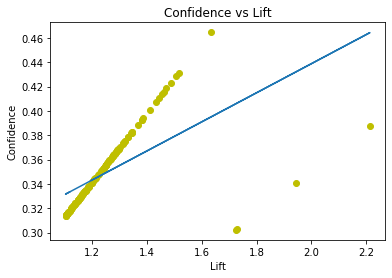

In [24]:
fit = np.polyfit(rules['lift'], rules['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.plot(rules['lift'], rules['confidence'], 'yo', rules['lift'], 
 fit_fn(rules['lift']))
plt.xlabel('Lift')
plt.ylabel('Confidence')
plt.title('Confidence vs Lift')
plt.show()

Confidence seems to increase linearly with lift.

### 1.4. Take a Look at Maximal Patterns: Compute Maximal Frequent Itemsets

In [5]:
min_support=0.01

# Compute itemsets ordered by length (descending)

frequent = all_stores.create_item_set(algorithm='fpgrowth', min_support=min_support, order=True, ascending=False)

# We can use a basic implementation to filter Maximal frequent itemsets

maximal_frequent = max_itemsets(frequent)

print('{} Maximal Itemsets with at least {} % support'.format(len(maximal_frequent), min_support*100))

maximal_frequent.head(10)

129 Maximal Itemsets with at least 1.0 % support


,support,itemsets
0,0.010654,"(Fresh Fruit, Pizza)"
1,0.010884,"(French Fries, Fresh Vegetables)"
2,0.010281,"(Fresh Vegetables, Cleaners)"
3,0.015586,"(Dips, Fresh Vegetables)"
4,0.011402,"(Jelly, Fresh Vegetables)"
5,0.015054,"(Cereal, Fresh Vegetables)"
6,0.015902,"(Fresh Vegetables, Deli Meats)"
7,0.011086,"(Fresh Vegetables, Flavored Drinks)"
8,0.011258,"(Fresh Vegetables, Spices)"
9,0.016506,"(Personal Hygiene, Fresh Vegetables)"


This example, uses a very basic approach to filter the maximum frequent items.

In alternative, we could use a more efficient approach. In this approach the itemsets are only created if they are maximum itemsets. This saves time cause there is no need to do an extensive filtering, over all itemsets. The algorithm has shown in the image bellow, only needs to identify the border nodes, and them by parsing the tree all other supersets will be identified.

![Grapth](graph.jpg)

*From:http://www.hypertextbookshop.com/dataminingbook/public_version/contents/chapters/chapter002/section004/blue/page001.html*

In [24]:
# Using efficient alternative


min_support=0.004

# Compute itemsets ordered by length (descending)

maximal_frequent = all_stores.create_item_set(algorithm='fpmax', min_support=min_support, order=True, ascending=False)

print('{} Maximal Itemsets with at least {} % support'.format(len(maximal_frequent), min_support*100))

maximal_frequent.head(10)

412 Maximal Itemsets with at least 0.4 % support


,support,itemsets
0,0.020805,"(Fresh Fruit, Fresh Vegetables, Soup)"
1,0.015083,"(Dried Fruit, Fresh Vegetables, Cheese)"
2,0.012193,"(Canned Vegetables, Fresh Vegetables, Fresh Fr..."
3,0.014982,"(Fresh Fruit, Fresh Vegetables, Wine)"
4,0.018908,"(Fresh Fruit, Cookies, Fresh Vegetables)"
5,0.014709,"(Fresh Fruit, Paper Wipes, Fresh Vegetables)"
6,0.015227,"(Fresh Vegetables, Soup, Cheese)"
7,0.020417,"(Fresh Fruit, Fresh Vegetables, Cheese)"
8,0.018318,"(Dried Fruit, Fresh Vegetables, Fresh Fruit)"
9,0.004026,"(Milk, Personal Hygiene)"


Given the conditions of this dataset, we need to use a very low minimum support, to ensure we get, all relevant maximal itemsets.

#### 1-Itemsets

In [25]:
# Compute itemsets ordered by length (descending)

maximal_frequent = all_stores.create_item_set(algorithm='fpmax', min_support=min_support, order=False, length=[1,1])

print('{} Maximal Itemsets with at least {} % support'.format(len(maximal_frequent), min_support*100))

maximal_frequent.head(10)

16 Maximal Itemsets with at least 0.4 % support


,support,itemsets
0,0.012883,(Fresh Fish)
1,0.012998,(Pancakes)
2,0.013156,(Fashion Magazines)
3,0.013357,(Auto Magazines)
4,0.013444,(Bagels)
5,0.013516,(Deodorizers)
6,0.013602,(Sunglasses)
7,0.013688,(Shellfish)
8,0.013703,(Toilet Brushes)
9,0.013746,(Pots and Pans)


Has expected, there is a low number of single itemsets, since most items will be present in supersets. This products pose a significant importance, since they are normally bought alone, this means they are the reason a person went to the store. 

But also that the store was not able to entice people to buy other products. A smart strategy would be to move this products closer to the convenience products we already found.

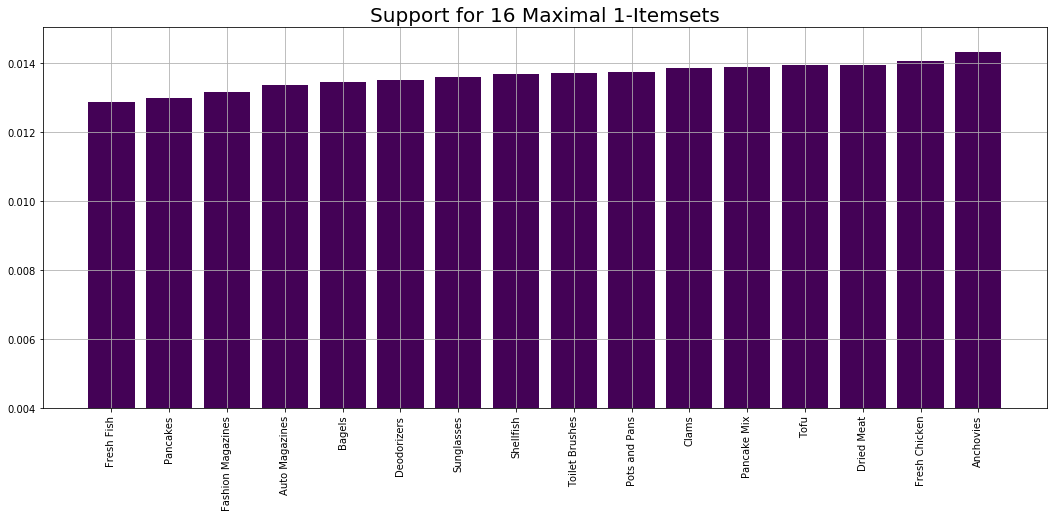

In [27]:
items = [list(item_set)[0] for item_set in maximal_frequent['itemsets'].values]

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.viridis(1)
plt.bar(items, maximal_frequent['support'].values, color=color)
plt.title('Support for {} Maximal 1-Itemsets'.format(len(maximal_frequent)), fontsize = 20)
plt.xticks(rotation = 90 )
plt.ylim(bottom=min_support)
plt.grid()
plt.show()

The low support for this single items, and their small deviations, indicates we are looking at rarely sold items. By looking at the items, we see mostly items of sporadic necessity or too expensive for most costumers to buy on a daily bases. 
But has sad before, they are very important items, when costumers decide to buy them, they will go specifically to the store to do so.

#### 2-Itemsets

In [30]:
# Compute itemsets ordered by length (descending)

min_support=0.02

maximal_frequent = all_stores.create_item_set(algorithm='fpmax', min_support=min_support, order=False, length=[2,2])

print('{} Maximal Itemsets with at least {} % support'.format(len(maximal_frequent), min_support*100))

maximal_frequent.head(10)

10 Maximal Itemsets with at least 2.0 % support


,support,itemsets
0,0.078549,"(Fresh Vegetables, Canned Vegetables)"
1,0.078966,"(Fresh Vegetables, Paper Wipes)"
2,0.080677,"(Wine, Fresh Vegetables)"
3,0.105422,"(Fresh Vegetables, Cookies)"
4,0.117227,"(Fresh Vegetables, Dried Fruit)"
5,0.020417,"(Cheese, Fresh Fruit)"
6,0.031201,"(Fresh Vegetables, Cheese)"
7,0.020805,"(Soup, Fresh Fruit)"
8,0.035701,"(Fresh Vegetables, Soup)"
9,0.175286,"(Fresh Vegetables, Fresh Fruit)"


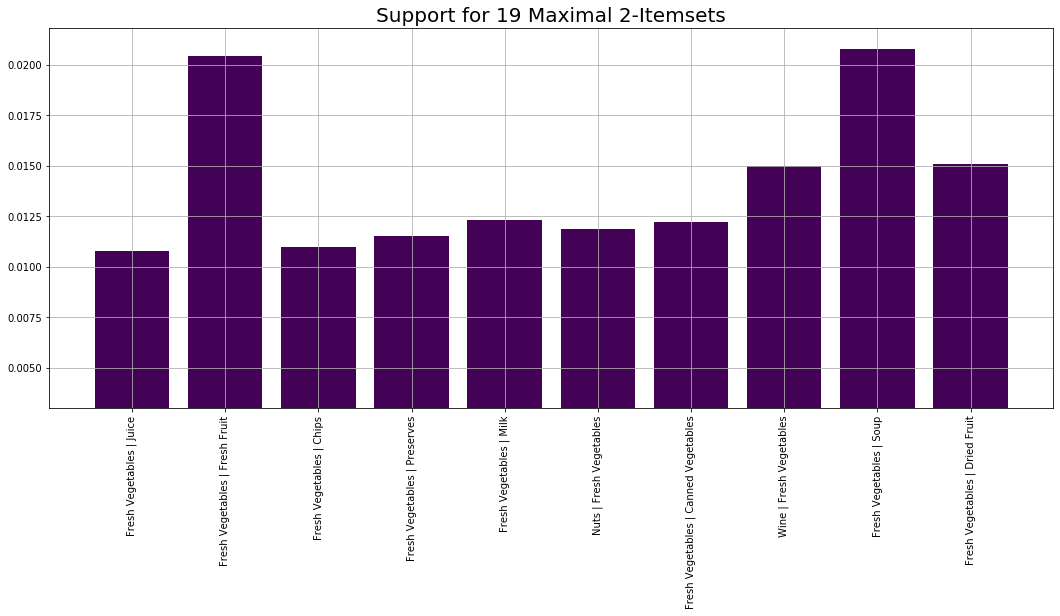

In [38]:
items = ['{} | {}'.format(list(item_set)[0], list(item_set)[1]) for item_set in maximal_frequent['itemsets'].values]

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.viridis(1)
plt.bar(items, maximal_frequent['support'].values, color=color)
plt.title('Support for {} Maximal 2-Itemsets'.format(len(maximal_frequent)), fontsize = 20)
plt.xticks(rotation = 90 )
plt.ylim(bottom=min_support)
plt.grid()
plt.show()

#### 3-Itemsets

In [39]:
# Compute itemsets ordered by length (descending)

min_support=0.003

maximal_frequent = all_stores.create_item_set(algorithm='fpmax', min_support=min_support, order=False, length=[3,3])

print('{} Maximal Itemsets with at least {} % support'.format(len(maximal_frequent), min_support*100))

maximal_frequent.head(10)

19 Maximal Itemsets with at least 0.3 % support


,support,itemsets
0,0.010769,"(Fresh Vegetables, Juice, Fresh Fruit)"
1,0.010798,"(Fresh Vegetables, Fresh Fruit, Batteries)"
2,0.010985,"(Fresh Vegetables, Chips, Fresh Fruit)"
3,0.011517,"(Fresh Vegetables, Preserves, Fresh Fruit)"
4,0.012337,"(Fresh Vegetables, Milk, Fresh Fruit)"
5,0.011402,"(Fresh Vegetables, Fresh Fruit, Chocolate Candy)"
6,0.011891,"(Nuts, Fresh Vegetables, Fresh Fruit)"
7,0.012193,"(Fresh Vegetables, Canned Vegetables, Fresh Fr..."
8,0.014709,"(Fresh Vegetables, Fresh Fruit, Paper Wipes)"
9,0.014982,"(Wine, Fresh Vegetables, Fresh Fruit)"


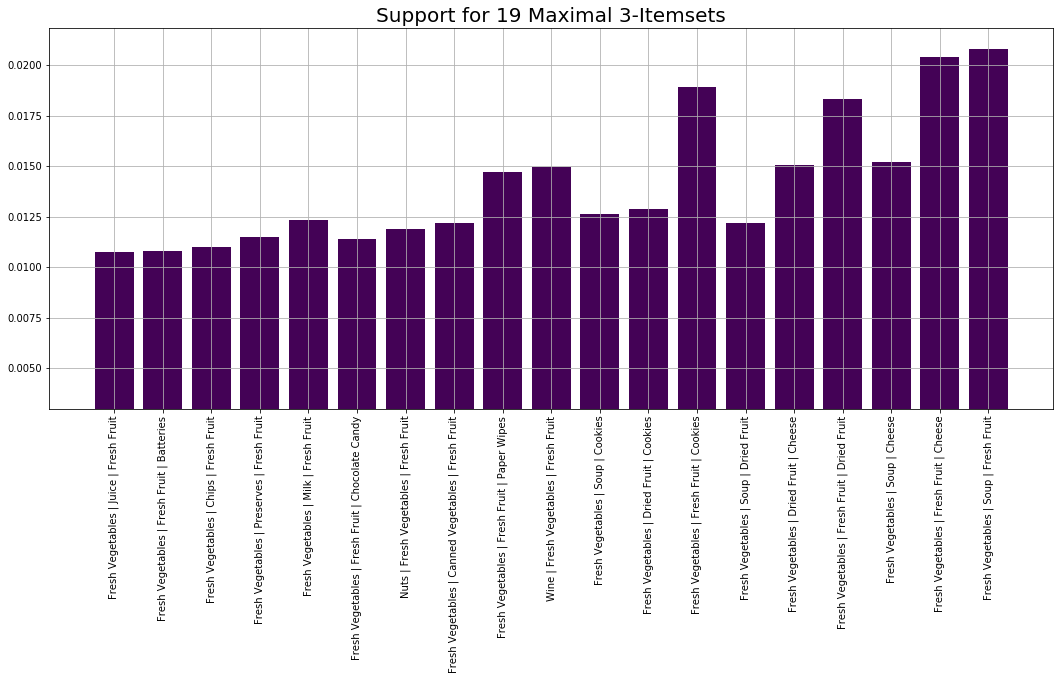

In [40]:
items = ['{} | {} | {}'.format(list(item_set)[0], list(item_set)[1], list(item_set)[2]) 
         for item_set in maximal_frequent['itemsets'].values]

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.viridis(1)
plt.bar(items, maximal_frequent['support'].values, color=color)
plt.title('Support for {} Maximal 3-Itemsets'.format(len(maximal_frequent)), fontsize = 20)
plt.xticks(rotation = 90 )
plt.ylim(bottom=min_support)
plt.grid()
plt.show()

### 1.5 Conclusions from Mining Frequent Patterns in All Stores

My initial theory was confirmed, many costumers go to this stores to buy fresh products, and end up buying other products.

I conclude that:

* Most frequent itemsets contain:

    * Daily/Fresh products (Fresh Vegetables, Fresh Fruit, Soup)
    * Convenience products (Cookies, Cheese, Dried Fruit, Wine)

    Bigger itemsets tend to have many daily products, and only one convenience product, has expected.

* Rule association
    
    Showed, that costumers that go to buy fresh products, can also end up buying other products they may need. So it is important to put fresh products in different areas, to induce costumers into walking around the store, and to find other products they might need. Like Meals or Hygiene Products.

* Maximal Itemsets

    Other more expensive/specific products like:

    * Fresh Fish
    * Fashion Magazines
    * Auto Magazines
    * Bagels
    * Deodorizers
    * Sunglasses
    * Shellfish
    * Toilet Brushes
    * Pots and Pans
    
    Are not bought so often, but are normally the reason costumers go to the store. Right now costumers that go to buy these items are not buying any other items, so putting some convenience products nearby, could increase profit.
    

**Stores Strategies**

A possible strategy would be to separate daily products in different parts of the store, and always have a convenience product close by. If they are in places costumers need to go but separately, costumers are probably more likely to buy, since other products already bought more likely to be forgotten. Also it makes costumers wander though the store, increasing the possibility of buying something they need.

## 2. Mining Frequent Itemsets and Association Rules: Looking for Differences between Stores

The 24 stores, whose transactions were analysed in Task 1, are in fact **different types of stores**:
* Deluxe Supermarkets: STORE_ID = 8, 12, 13, 17, 19, 21
* Gourmet Supermarkets: STORE_ID = 4, 6
* Mid-Size Grocerys: STORE_ID = 9, 18, 20, 23
* Small Grocerys: STORE_ID = 2, 5, 14, 22
* Supermarkets: STORE_ID = 1, 3, 7, 10, 11, 15, 16

In this context, in this second task you should compute frequent itemsets and association rules for specific groups of stores, and then compare the store specific results with those obtained when all transactions were analysed independently of the type of store. 

**The goal is to find similarities and differences in buying patterns according to the types of store. Do popular products change? Are there buying patterns specific to the type of store?**

### 2.1. Analyse Deluxe Supermarkets and Gourmet Supermarkets

Here you should analyse transactions from **Deluxe Supermarkets (STORE_ID = 8, 12, 13, 17, 19, 21) and Gourmet Supermarkets (STORE_ID = 4, 6) together**.

#### 2.1.1. Load/Preprocess the Dataset

**You might need to change a bit the preprocessing, although most of it should be reused.**

In [41]:
stores = {
    'Deluxe/Gourmet' : ['8', '12', '13', '17', '19', '21', '4', '6'],
}

In [43]:
Deluxe_Gourmet = store_groups(csv_file=csv_file, stores=stores)['Deluxe/Gourmet']
Deluxe_Gourmet.dataset.head()

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,...,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


##### EDA

In [44]:
print('{} Items'.format(len(Deluxe_Gourmet.dataset.columns)))
print('{} Transactions'.format(len(Deluxe_Gourmet.dataset.values)))

102 Items
31314 Transactions


Roughly half of the full dataset. Still maintains good proportions.

In [45]:
percents = []
items = Deluxe_Gourmet.dataset.columns
for item in items:
    percents.append(Deluxe_Gourmet.dataset[item].value_counts('True')[1])
print('Mean Presence: {} % [+- {}]'.format(round(mean(percents)*100,1), round(stdev(percents)*100, 1)))
print('Maximum Presence: {} %'.format(round(max(percents)*100,1)))
print('Minimum Presence: {} %'.format(round(min(percents)*100,1)))

Mean Presence: 4.1 % [+- 3.8]
Maximum Presence: 29.0 %
Minimum Presence: 1.3 %


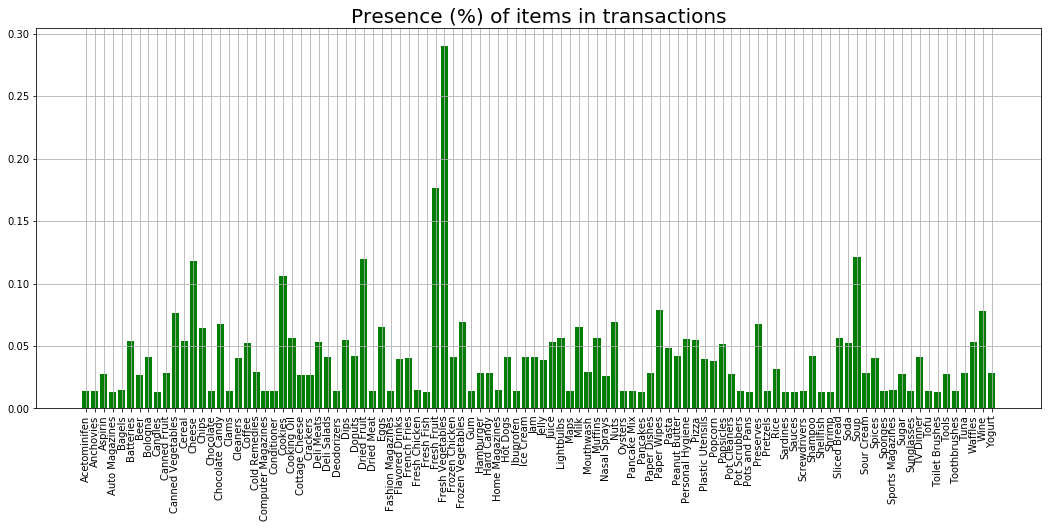

In [47]:
plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.ocean(1)
plt.bar(items, percents, color=color)
plt.title('Presence (%) of items in transactions', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

In [48]:
N = 10
top = get_n(percents, items, N)
top

{'Canned Vegetables': 0.07606821230120712,
 'Cheese': 0.11803027399885035,
 'Cookies': 0.10624640735773136,
 'Dried Fruit': 0.11940346171041706,
 'Fresh Fruit': 0.17634284984352047,
 'Fresh Vegetables': 0.29015775691384044,
 'Frozen Vegetables': 0.06936194673309062,
 'Paper Wipes': 0.07916586830171808,
 'Soup': 0.1213834067829086,
 'Wine': 0.07792041898192502}

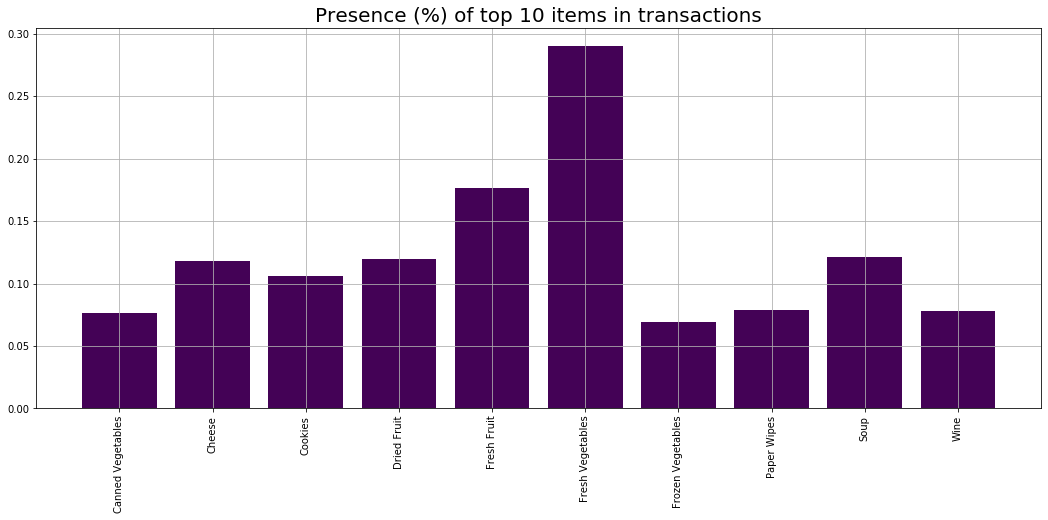

In [49]:
plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.viridis(1)
plt.bar(list(top.keys()), list(top.values()), color=color)
plt.title('Presence (%) of top {} items in transactions'.format(N), fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

In [51]:
N = 50
bottom = get_n(percents, items, N, top=False)

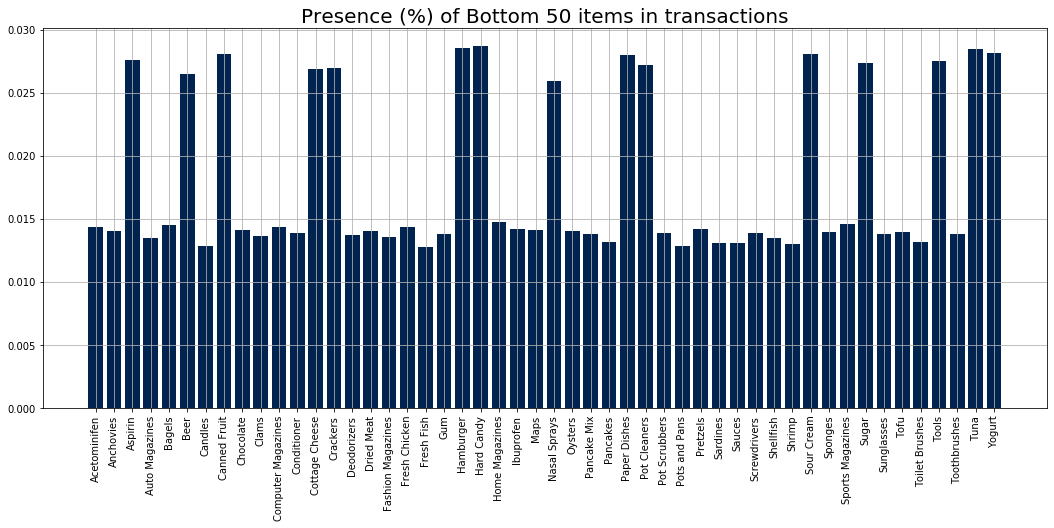

In [52]:
plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.cividis(1)
plt.bar(list(bottom.keys()), list(bottom.values()), color=color)
plt.title('Presence (%) of Bottom {} items in transactions'.format(N), fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

With this initial EDA, we can conclude that this dataset is a smaller version of the other, that follows similar data distributions and patterns.

So no major changes are expected.

#### 2.1.2. Compute Frequent Itemsets

#### Top Products

In [53]:
min_support=0.1

frequent = Deluxe_Gourmet.create_item_set(min_support=min_support, order=False)

print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head()

6 Itemsets with at least 10.0 % support


,support,itemsets
0,0.176343,(Fresh Fruit)
1,0.290158,(Fresh Vegetables)
2,0.121383,(Soup)
3,0.119403,(Dried Fruit)
4,0.118030,(Cheese)


#### Organized By Length

In [55]:
min_support=0.005

frequent = Deluxe_Gourmet.create_item_set(min_support=min_support, ascending=False)

print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head(10)

376 Itemsets with at least 0.5 % support


,support,itemsets
0,0.005429,"(Fresh Vegetables, Fresh Fruit, Cheese)"
1,0.006100,"(Fresh Vegetables, Fresh Fruit, Cookies)"
2,0.005014,"(Fresh Vegetables, Fresh Fruit, Paper Wipes)"
3,0.005014,"(Fresh Vegetables, Dried Fruit, Fresh Fruit)"
4,0.008048,"(Fresh Vegetables, Soup, Fresh Fruit)"
5,0.014818,"(Fresh Vegetables, Soda)"
6,0.005620,"(Hard Candy, Fresh Fruit)"
7,0.006451,"(Cookies, Coffee)"
8,0.010538,"(Cheese, Cookies)"
9,0.012391,"(Soup, Cookies)"


##### 1-Itemsets

In [56]:
min_support=0.05

frequent = Deluxe_Gourmet.create_item_set(min_support=min_support, order=False, length=[1,1])

print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head(10)

31 Itemsets with at least 5.0 % support


,support,itemsets
0,0.176343,(Fresh Fruit)
1,0.056652,(Sliced Bread)
2,0.064348,(Chips)
3,0.290158,(Fresh Vegetables)
4,0.077920,(Wine)
5,0.056556,(Muffins)
6,0.056141,(Cooking Oil)
7,0.121383,(Soup)
8,0.065530,(Milk)
9,0.052788,(Deli Meats)


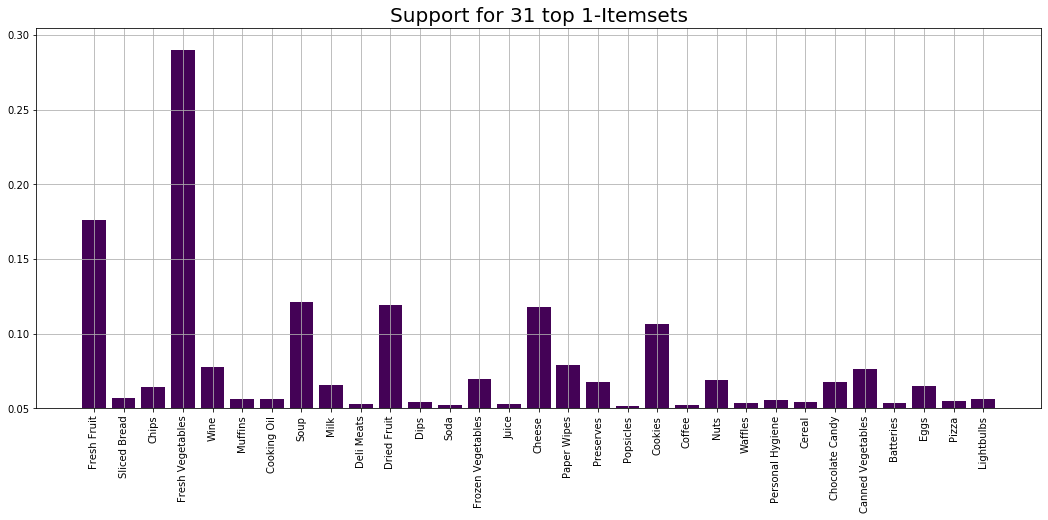

In [57]:
items = [list(item_set)[0] for item_set in frequent['itemsets'].values]

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.viridis(1)
plt.bar(items, frequent['support'].values, color=color)
plt.title('Support for {} top 1-Itemsets'.format(len(frequent)), fontsize = 20)
plt.xticks(rotation = 90 )
plt.ylim(bottom=min_support)
plt.grid()
plt.show()

##### 2-Itemsets

In [58]:
min_support=0.015

frequent = Deluxe_Gourmet.create_item_set(min_support=min_support, order=False, length=[2,2])

print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head(10)

31 Itemsets with at least 1.5 % support


,support,itemsets
0,0.051862,"(Fresh Vegetables, Fresh Fruit)"
1,0.016031,"(Fresh Vegetables, Sliced Bread)"
2,0.017979,"(Fresh Vegetables, Chips)"
3,0.020055,"(Wine, Fresh Vegetables)"
4,0.017181,"(Fresh Vegetables, Muffins)"
5,0.016574,"(Cooking Oil, Fresh Vegetables)"
6,0.022450,"(Soup, Fresh Fruit)"
7,0.036214,"(Fresh Vegetables, Soup)"
8,0.018235,"(Fresh Vegetables, Milk)"
9,0.016382,"(Fresh Vegetables, Deli Meats)"


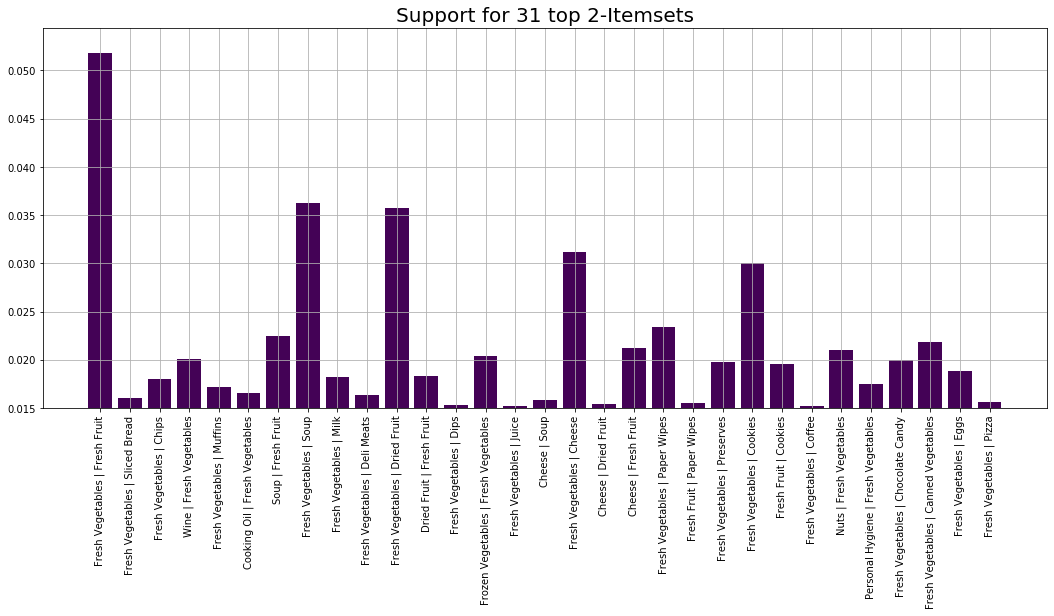

In [59]:
itemsets = ['{} | {}'.format(list(item_set)[0], list(item_set)[1]) for item_set in frequent['itemsets'].values]

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.viridis(1)
plt.bar(itemsets, frequent['support'].values, color=color)
plt.title('Support for {} top 2-Itemsets'.format(len(frequent)), fontsize = 20)
plt.xticks(rotation = 90 )
plt.ylim(bottom=min_support)
plt.grid()
plt.show()

##### 3-Itemsets

In [60]:
min_support=0.003

frequent = Deluxe_Gourmet.create_item_set(min_support=min_support, order=False, length=[3,3])

print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head(10)

22 Itemsets with at least 0.3 % support


,support,itemsets
0,0.003641,"(Fresh Vegetables, Chips, Fresh Fruit)"
1,0.004215,"(Wine, Fresh Vegetables, Fresh Fruit)"
2,0.008048,"(Fresh Vegetables, Soup, Fresh Fruit)"
3,0.003385,"(Fresh Vegetables, Milk, Fresh Fruit)"
4,0.003513,"(Fresh Vegetables, Soup, Dried Fruit)"
5,0.005014,"(Fresh Vegetables, Dried Fruit, Fresh Fruit)"
6,0.003162,"(Fresh Vegetables, Juice, Fresh Fruit)"
7,0.004407,"(Fresh Vegetables, Soup, Cheese)"
8,0.004631,"(Fresh Vegetables, Dried Fruit, Cheese)"
9,0.005429,"(Fresh Vegetables, Fresh Fruit, Cheese)"


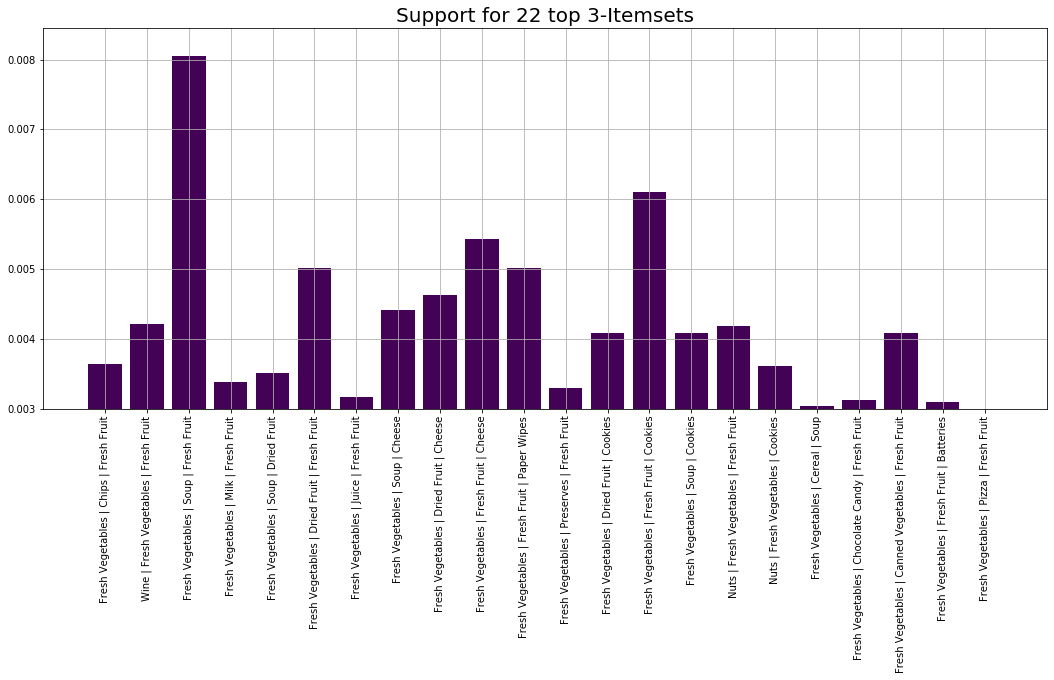

In [61]:
itemsets = ['{} | {} | {}'.format(list(item_set)[0], list(item_set)[1], list(item_set)[2]) 
            for item_set in frequent['itemsets'].values]

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.viridis(1)
plt.bar(itemsets, frequent['support'].values, color=color)
plt.title('Support for {} top 3-Itemsets'.format(len(frequent)), fontsize = 20)
plt.xticks(rotation = 90 )
plt.ylim(bottom=min_support)
plt.grid()
plt.show()


#### 2.1.3. Generate Association Rules from Frequent Itemsets

#### Main Rule analyses

In [ ]:
# Recomputing frequent itemsets with low min_support
min_support=0.001
frequent = all_stores.create_item_set(min_support=min_support, order=False, inplace=True)
print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head(10)

In [ ]:
confidence = 0.4
lift = 1.1

rules = all_stores.create_association_rules(metrics={'confidence': confidence, 'lift': lift})
print('{} Rules with at least {} % confidence and lift {}'.format(len(rules), confidence*100, lift))
rules.sort_values('confidence', inplace=True, ascending=False)
rules.reset_index(drop=True, inplace=True)
rules

All items have lead to buying Fresh Vegetables, this is not very informative, mostly this is due to the fact that Fresh Vegetables, are very commonly bought. But we already new that.

Nevertheless some important information can be obtained. There seems to be a big connection between going in to buy shampoo and pizza, and ending up buying fresh vegetables. Although Fresh Vegetables appear as a consequence, with the knowledge of the dataset, and some insights in the area, I think is obvious, that costumers go to buy a daily product and end up buying other products. 

In [ ]:
confidence = 0.2
lift = 1.1

rules = all_stores.create_association_rules(metrics={'confidence': confidence, 'lift': lift})
print('{} Rules with at least {} % confidence and lift {}'.format(len(rules), confidence*100, lift))
rules['consequents'].value_counts(True)

Even reducing confidence, 70% of rules still have Fresh Vegetables as a consequence.

In [ ]:
index = [i for i, rule in enumerate(rules['consequents']) if 'Fresh Vegetables' in list(rule)]
rules.drop(labels=index, axis=0, inplace=True)
rules.sort_values('confidence', inplace=True, ascending=False)
rules.reset_index(drop=True, inplace=True)
rules

By removing Fresh Vegetable, we can see other rules.

Mostly go according to what we were expecting, with costumers going in to buy daily products and bring some other necessities.

#### Confidence vs Lift

In [ ]:
confidence = 0.3
lift = 1.1

rules = all_stores.create_association_rules(metrics={'confidence': confidence, 'lift': lift})
print('{} Rules with at least {} % confidence and lift {}'.format(len(rules), confidence*100, lift))

In [ ]:
fit = np.polyfit(rules['lift'], rules['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.plot(rules['lift'], rules['confidence'], 'yo', rules['lift'], 
 fit_fn(rules['lift']))
plt.xlabel('Lift')
plt.ylabel('Confidence')
plt.title('Confidence vs Lift')
plt.show()

Confidence seems to increase linearly with lift.



#### 2.1.4.  Deluxe/Gourmet Supermarkets versus All Stores

Discuss the similarities and diferences between the results obtained in task 1. (frequent itemsets and association rules found in transactions from all stores) and those obtained above (frequent itemsets and association rules found in transactions only from Deluxe/Gourmet Supermarkets).

Write text in cells like this 
